## Encode chess position

In [1]:
from lib.dataset_utils import nb_channels, encode_position, store_many_hdf5
from lib.score_getter import ScoreGetter, Engine

import chess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from multiprocessing import current_process

We load a dataset containing millions of unique chess position represented by the [FEN](https://fr.wikipedia.org/wiki/Notation_Forsyth-Edwards) notation.

In [2]:
df = pd.read_csv("/media/gaetan/HDD/IA/Chess/Datasets/fen_dataset.csv")
df = df.sample(frac=1)

We create our train/test dataset.

Each position is encoded as an image of $8\times8$ "pixels" with $15$ channels
($12$ representing each chess pieces, $1$ for the actual player, $1$
for the en-passant square and $1$ for the castling rights). Along this encoded position, we store
the score given by Stockfish 14.

In [3]:
score_getter = ScoreGetter("bin/stockfish", Engine.STOCKFISH)

nb_positions = 1400000
positions = []
scores = []

# Status bar configuration
current = current_process()
pos = current._identity[0]-1 if len(current._identity) > 0 else 0
pbar = tqdm(total=nb_positions, desc="Encoding", position=pos)

for i in range(nb_positions):
  pbar.update(1)
  fen = df["board"][i]
  board = chess.Board(fen)
  if board.is_game_over(): continue
  try:
      scores.append(score_getter.get_score(board.fen()))
      positions.append(encode_position(board))
  except Exception as e:
    if str(e) == "[Errno 32] Broken pipe":
        score_getter.restart()
    continue
scores = np.array(scores, dtype=np.float32).reshape(-1, 1)
positions = np.array(positions, dtype=np.float32)
print(f"Number of positions: {positions.shape[0]}")

Encoding: 100%|█████████▉| 399980/400000 [18:29<00:00, 363.29it/s]

Number of positions: 397082


We look at the distribution of the scores

Text(0.5, 1.0, 'Distribution of evaluations')

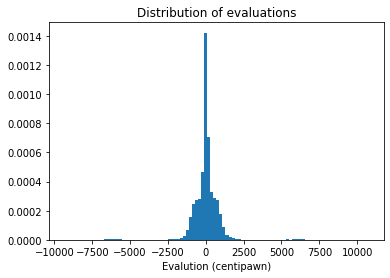

In [4]:
plt.hist(scores, bins=100, density=True)
plt.xlabel("Evalution (centipawn)")
plt.title("Distribution of evaluations")
_ = plt.savefig("results/distribution.pdf")

In [5]:
pd.Series(scores.reshape(-1)).describe()

count    397082.000000
mean         29.149530
std         932.991821
min       -9358.000000
25%        -235.750000
50%          29.000000
75%         303.000000
max       10751.000000
dtype: float64

We save the resulting dataset using HDF5.

In [6]:
directory = "/media/gaetan/HDD/IA/Chess/Datasets/SE_ResNet/"
store_many_hdf5(positions, scores, directory, tag="_train")

Encoding: 100%|██████████| 400000/400000 [18:40<00:00, 363.29it/s]